In [ ]:
# Let's load some other packages we need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from config.dir import DATA_DIR
import itertools
import time
%matplotlib inline
import nibabel as nib # common way of importing nibabel

# Nifti 

Nifti, that most neuroimaging packages should support. As such, usually the first step in any (f)MRI preprocessing pipeline is to convert the scanner-specific files (e.g., PAR/RECs) to nifti

In [5]:
subject = 'sub-UTS01'
session = 'ses-10'
fmri_file = os.path.join(DATA_DIR, 'ds003020', subject,session,'func',f"{subject}_{session}_task-catfishingstrangerstofindmyself_bold.nii.gz")
#fmri_file = '/Users/genevievelam/Documents/GitHub/ds003020/sub-UTS01/ses-10/func/sub-UTS01_ses-10_task-catfishingstrangerstofindmyself_bold.nii.gz'
img = nib.load(fmri_file)


In [6]:
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


In [7]:
print(img.shape)

(84, 84, 54, 346)


### The three parts of nifti images
Nifti images can be roughly divided into three “parts”:

1. The header with metadata;

2. The image data;

3. The affine matrix

All three parts are of course represented in nibabel’s Nifti1Image class. Let’s go through them one by one.



# The header 
The header with metadata provides essential information about the nifti file, such as dimensions, voxel size, data type, and acquisition parameters.

In [7]:
hdr = img.header
hdr.get_zooms()  # it's a 2.7z x 2.7 x 2.97 x 0.7 mm MRI file!

(2.6190476, 2.6190476, 2.6000001, 2.0)

In [8]:
hdr.get_xyzt_units()

('mm', 'sec')

# Getting the data 
this is a typical fMRI data 4D arrays. This 4D array as a series of 3D arrays (volumes), in which the fourth dimension represents time (as shown in the image below).

In [9]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.ndarray'>
(84, 84, 54, 346)


In [10]:
# printing a small 3x3x3 volume of voxels from the first timepoint
print(img_data[38:41, 38:41, 20:23, 0])

[[[ 8366. 15275. 19633.]
  [11606. 13266. 19525.]
  [11480. 16435. 22411.]]

 [[11208. 14487. 21033.]
  [ 9024. 15411. 24254.]
  [ 9587. 23079. 29817.]]

 [[17831. 28437. 31269.]
  [25773. 34457. 36764.]
  [24626. 32597. 31656.]]]


For example, we can visualize a single slice (e.g., 
) of the first volume (
) as follows:

Shape of slice: (84, 54)


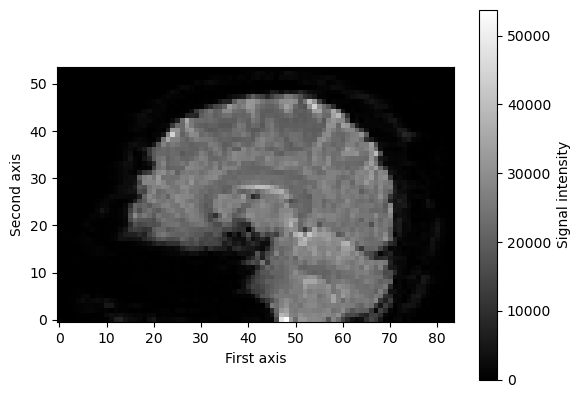

In [105]:
mid_slice_x_fmri = img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))
plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

we can also look at fMRI data from a different perspective, that is, from the time dimension! For example, we could extract a single voxel’s time series (i.e., how the signal intensity varies across time) and plot the signal intensity values of that voxel across time. First, let’s extract the time series of one particular voxel (e.g., the middle one across all spatial dimensions):

In [106]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 20))  # 3 timepoints
# Loop over the first 3 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((40, 10), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

Voxel timeseries shape: (346,)


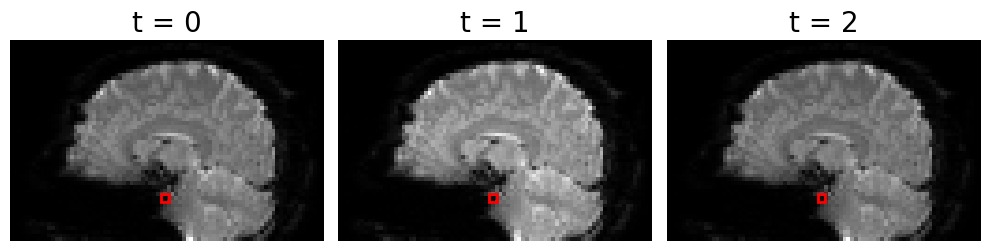

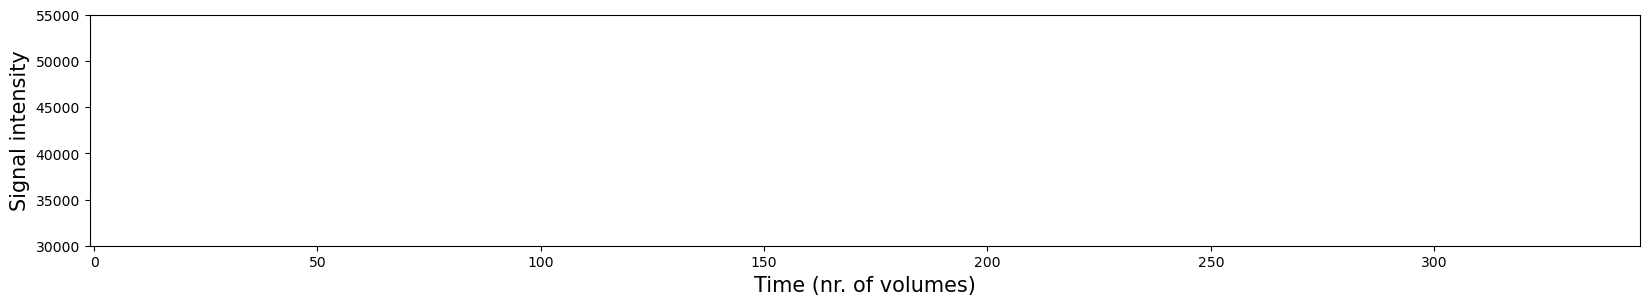

In [107]:
mid_vox_ts = img_data[39, 44, 22, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))
plt.figure(figsize=(20, 3))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
plt.ylim(30000, 55000)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

# The affine

In fMRI, the affine matrix is a 4x4 matrix that describes how the 3D spatial coordinates of a voxel in an fMRI image relate to the 3D coordinates in scanner space (often Right-Anterior-Superior or RAS+). It essentially defines the transformation from voxel coordinates to real-world coordinates. This matrix combines various transformations like rotations, translations, and scaling to map the brain's image to its anatomical location. 

In [84]:
# import some stuff if you haven't done that already
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline

You can clearly see that the first voxel axis represents the sagittal dimension (left ←→ right), the second voxel axis represents the coronal dimension (anterior ←→ posterior), and the third voxel axis represents the axial dimension (inferior ←→ superior).

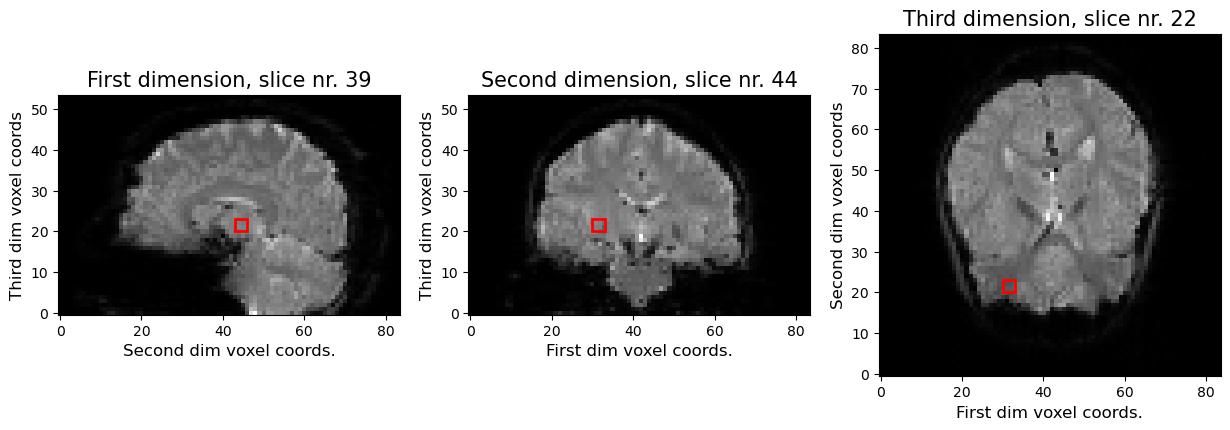

In [100]:
#  our voxel coordinate (39,44,22)
import matplotlib.patches as patches
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(img_data[39, :, :,0].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 39', fontsize=15)
rect = patches.Rectangle((43, 20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(img_data[:, 44, :,0].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 44', fontsize=15)
rect = patches.Rectangle((30,20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(img_data[:, :, 22,0].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 22', fontsize=15)
rect = patches.Rectangle(( 30,20), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

fig

The corresponding to the actual coordinate for in fmri

In [108]:
A = img.affine
xyz1 = A @ np.array([39,44,22, 0])
print(xyz1)

[-102.14285803 -115.23809624   57.20000315    0.        ]


In [109]:
mid_vox_ts = img_data[39, 44, 22, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))


Voxel timeseries shape: (346,)
